<a href="https://colab.research.google.com/github/Waqasii/WeatherClassificationSystem/blob/main/CNN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Install data split library

!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Import required packages

import json
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import shutil
import PIL
import PIL.Image as PI
import splitfolders
import shutil
# setting seed and clearing session
tf.keras.backend.clear_session()# clear session to save model space
# setting seed to keep reproducibililty
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
# Download and unzip data
!wget "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip";
!unzip "4drtyfjtfy-1.zip";
!unzip "dataset2.zip"

#Check all image sizes and store in list
l=[]
for img in os.listdir('dataset2'):
    image=PI.open("dataset2/"+img)
    l.append(image.size)
    

--2022-10-17 07:48:02--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 3.5.64.142
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|3.5.64.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  10.8MB/s    in 10s     

2022-10-17 07:48:14 (8.73 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]

Archive:  4drtyfjtfy-1.zip
  inflating: dataset2.zip            
Archive:  dataset2.zip
   creating: dataset2/
  inflating: dataset2/cloudy1.jpg    
  inflating: dataset2/cloudy10.jpg   
  inflating: dataset2/cloudy100.jpg  
  inflating: dataset2/cloudy101.jpg  
  inflating: dataset2/cloudy102

In [ ]:
## Make folders for all the available classes
class_names=["cloudy","rain","shine","sunrise"]
for val in class_names:
    os.makedirs("data/{}".format(val),exist_ok=True)

## Copy the images to their respective folder

for img in os.listdir('dataset2'):
    for label in class_names:
        if label in img:
            shutil.copy('./dataset2/'+img,'./data/{}'.format(label))        

#### Defining Variables

In [ ]:
img_height = 128
img_width = 128
dataset_size=len(os.listdir('dataset2'))
train_size=.7
validation_size=.2
test_size=.1
split_seed=1  #to ensure same split for data always

{'sunrise': 357, 'cloudy': 300, 'rain': 215, 'shine': 253} 



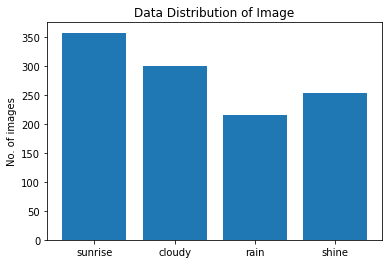

In [ ]:
## Class distribution
data_count={val:len(os.listdir('/content/data/{}'.format(val))) for val in os.listdir('data')}
print(data_count,'\n')

plt.bar(list(data_count.keys()), data_count.values(),)
plt.title("Data Distribution of Image",)
plt.ylabel("No. of images")
plt.show()

In [ ]:
## Split Data in train, Validation and test data

splitfolders.ratio("data", output="output",
    seed=split_seed, ratio=(train_size,validation_size,test_size), group_prefix=None, move=False,)

Copying files: 1125 files [00:00, 1412.53 files/s]


In [ ]:
## Classwise distrubution of splitted dataset

for val in os.listdir('output'):
    for typ in os.listdir('output/'+val):
        print(val,"->",typ,"->",len(os.listdir('/content/output/{}/{}'.format(val,typ))))

train -> sunrise -> 249
train -> cloudy -> 210
train -> rain -> 150
train -> shine -> 177
test -> sunrise -> 37
test -> cloudy -> 30
test -> rain -> 22
test -> shine -> 26
val -> sunrise -> 71
val -> cloudy -> 60
val -> rain -> 43
val -> shine -> 50


In [ ]:
## To save split data
# !zip -r -v  'split_data.zip' data/

In [ ]:
## Convert image and apply augmentation

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.5, # Shifting image width by 40%
      height_shift_range=0.2,# Shifting image height by 40%
      shear_range=0.2,       # Rotation across X-axis by 20%
      zoom_range=0.4,        # Image zooming by 30%
      horizontal_flip=True,
      
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    "/content/output/train",
    target_size = (128, 128),
    shuffle=True,
    seed=1,
    class_mode = 'categorical',
    batch_size = 8)


datagen_test = ImageDataGenerator(rescale=1./255,
                                  
    )


validation_generator=datagen_test.flow_from_directory(
    "/content/output/val",
    target_size = (128, 128),
    class_mode = 'categorical',
    seed=1,
    shuffle=True,
    batch_size = 8)
# test_datagen=ImageDataGenerator(
#     rescale=1./255,
# )
# test_generator=test_datagen.flow_from_directory(
#     "/content/output/test",
#     target_size = (128, 128),
#     class_mode = 'categorical',
#     )


test_generator = datagen_test.flow_from_directory(
        "/content/output/test",
         target_size = (128, 128),
        batch_size=8,
        shuffle=True,
        seed=1,
        class_mode='categorical',)


Found 786 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 115 images belonging to 4 classes.


##LABELS dict for datagen

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}


In [ ]:
#########################################
# optimizer: 'adam','rmsprop'
# monitor: what parameter to monitor for earlystopping ( loss,val_loss,accuracy)
# mode: min or max for monitor
# epochs: total no of epochs to try
# batch_size: batch size
# wait: how long to wait before no change in monitored parameter 
# c: counter to given numbered name to saved files
#########################################



def train_model(optimizer,monitor,mode,epochs,batch_size,c,wait=20,activation='relu',metrics = ['accuracy']):
    ## Defining model architecture

    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation=activation, input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4,seed=1),
        
        tf.keras.layers.Conv2D(128, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.5,seed=1),
        
        tf.keras.layers.Conv2D(128, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4,seed=1),
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation=activation),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                optimizer =optimizer ,
                metrics = metrics,)
    filepath="model_weight{}.hdf5".format(c)
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2,
                              patience=5, min_lr=0.00001,)
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, mode=mode,)
    es = EarlyStopping(monitor=monitor,mode=mode,patience=wait,restore_best_weights=True)
    callbacks_list = [checkpoint]
    history = model.fit(
        train_generator,
        batch_size=batch_size,  
        epochs = epochs,
        callbacks=[callbacks_list,reduce_lr],
        verbose = 2,
        validation_data=validation_generator)
    
    ##SAVE MODEL ARCHITECTURE AND WEIGHT
    
    # with open('history{}.json'.format(c), 'w') as f:
    #     json.dump(history.history, f)
    model.save("model{}.h5".format(c))  
    print("Model Trained and Saved")  
    os.makedirs('/content/drive/MyDrive/ML Project 1/{}'.format(c),exist_ok=True) 
    shutil.copy("model{}.h5".format(c) ,"/content/drive/MyDrive/ML Project 1/{}".format(c))
    shutil.copy("model_weight{}.hdf5".format(c), '/content/drive/MyDrive/ML Project 1/{}'.format(c))
    shutil.copy('history{}.json'.format(c), '/content/drive/MyDrive/ML Project 1/{}'.format(c))
    

    ##SAVE PLOTS OF ACCURACY AND LOSS
    fig =plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')


    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()
    fig.savefig('/content/drive/MyDrive/ML Project 1/{}/plot.jpg'.format(c))

    score = model.evaluate(test_generator,verbose=1,)

    print('\n', 'Test accuracy:', score[1]*100,"%")

    return history

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.52679, saving model to model_weight35.hdf5
99/99 - 9s - loss: 1.3529 - accuracy: 0.3664 - val_loss: 1.2584 - val_accuracy: 0.5268 - lr: 0.0100 - 9s/epoch - 93ms/step
Epoch 2/200

Epoch 2: val_accuracy improved from 0.52679 to 0.60714, saving model to model_weight35.hdf5
99/99 - 8s - loss: 1.0843 - accuracy: 0.5191 - val_loss: 0.9687 - val_accuracy: 0.6071 - lr: 0.0100 - 8s/epoch - 85ms/step
Epoch 3/200

Epoch 3: val_accuracy improved from 0.60714 to 0.68304, saving model to model_weight35.hdf5
99/99 - 11s - loss: 0.9381 - accuracy: 0.5967 - val_loss: 0.8331 - val_accuracy: 0.6830 - lr: 0.0100 - 11s/epoch - 108ms/step
Epoch 4/200

Epoch 4: val_accuracy improved from 0.68304 to 0.73214, saving model to model_weight35.hdf5
99/99 - 10s - loss: 0.9146 - accuracy: 0.6310 - val_loss: 0.7853 - val_accuracy: 0.7321 - lr: 0.0100 - 10s/epoch - 97ms/step
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.73214
99/99 - 8s - loss: 0.7

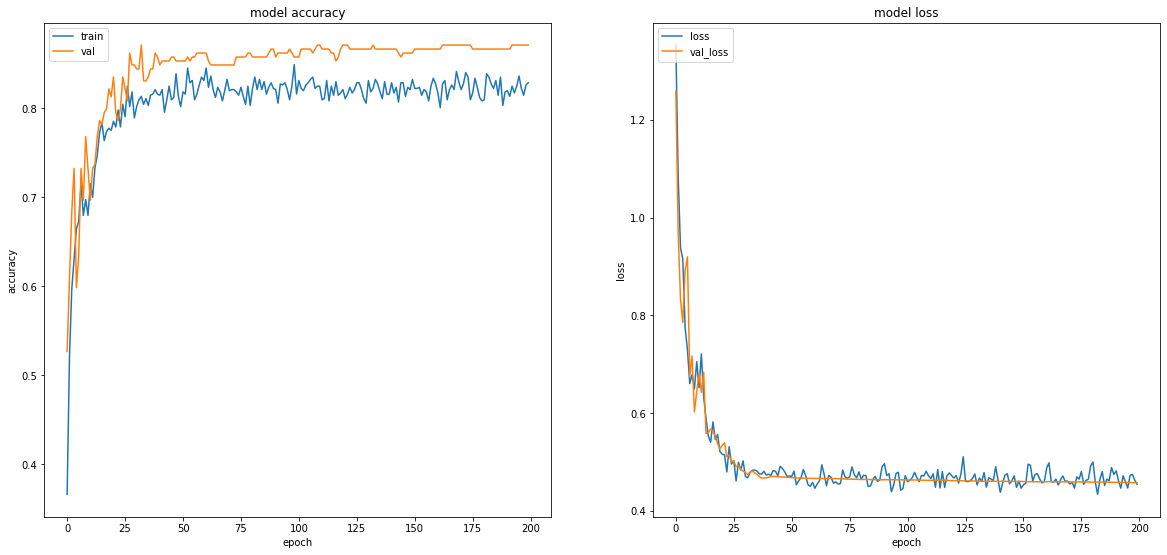

15/15 [==============================] - 1s 49ms/step - loss: 0.4635 - accuracy: 0.8609

 Test accuracy: 86.08695864677429 %


In [ ]:
# train_model('sgd','val_accuracy','max',200,32,34,15,)

a=train_model('sgd','val_accuracy','max',200,32,35,15,)

## All models performance 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 237ms/step


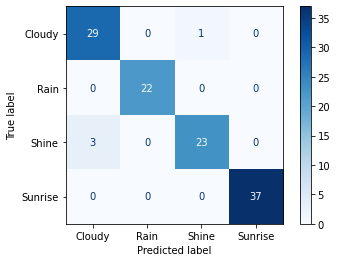

4



              precision    recall  f1-score   support

      Cloudy       0.91      0.97      0.94        30
        Rain       1.00      1.00      1.00        22
       Shine       0.96      0.88      0.92        26
     Sunrise       1.00      1.00      1.00        37

    accuracy                           0.97       115
   macro avg       0.97      0.96      0.96       115
weighted avg       0.97      0.97      0.97       115

15/15 [==============================] - 3s 187ms/step - loss: 0.0887 - accuracy: 0.9652

 Test accuracy: 96.52174115180969 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 237ms/step


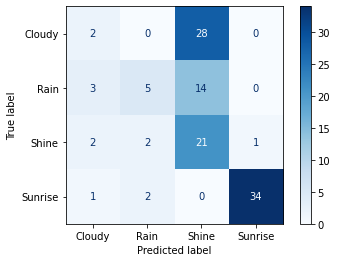

3



              precision    recall  f1-score   support

      Cloudy       0.25      0.07      0.11        30
        Rain       0.56      0.23      0.32        22
       Shine       0.33      0.81      0.47        26
     Sunrise       0.97      0.92      0.94        37

    accuracy                           0.54       115
   macro avg       0.53      0.51      0.46       115
weighted avg       0.56      0.54      0.50       115

15/15 [==============================] - 2s 113ms/step - loss: 0.8973 - accuracy: 0.5391

 Test accuracy: 53.913044929504395 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 234ms/step


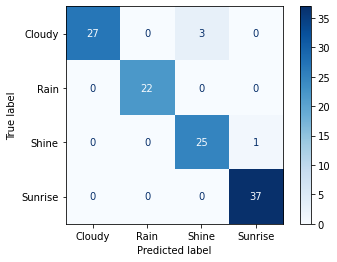

2



              precision    recall  f1-score   support

      Cloudy       1.00      0.90      0.95        30
        Rain       1.00      1.00      1.00        22
       Shine       0.89      0.96      0.93        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.97       115
   macro avg       0.97      0.97      0.96       115
weighted avg       0.97      0.97      0.97       115

15/15 [==============================] - 2s 119ms/step - loss: 0.1853 - accuracy: 0.9652

 Test accuracy: 96.52174115180969 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 236ms/step


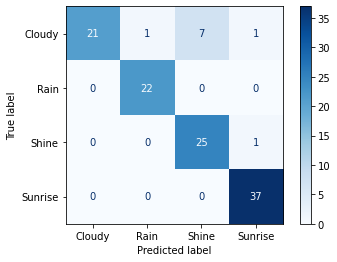

1



              precision    recall  f1-score   support

      Cloudy       1.00      0.70      0.82        30
        Rain       0.96      1.00      0.98        22
       Shine       0.78      0.96      0.86        26
     Sunrise       0.95      1.00      0.97        37

    accuracy                           0.91       115
   macro avg       0.92      0.92      0.91       115
weighted avg       0.93      0.91      0.91       115

15/15 [==============================] - 2s 121ms/step - loss: 0.2083 - accuracy: 0.9130

 Test accuracy: 91.30434989929199 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 243ms/step


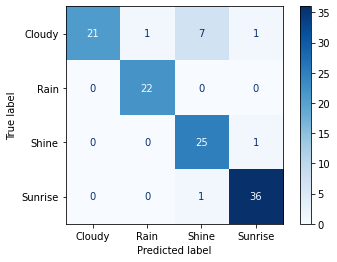

8.1



              precision    recall  f1-score   support

      Cloudy       1.00      0.70      0.82        30
        Rain       0.96      1.00      0.98        22
       Shine       0.76      0.96      0.85        26
     Sunrise       0.95      0.97      0.96        37

    accuracy                           0.90       115
   macro avg       0.92      0.91      0.90       115
weighted avg       0.92      0.90      0.90       115

15/15 [==============================] - 2s 121ms/step - loss: 0.2226 - accuracy: 0.9043

 Test accuracy: 90.4347836971283 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 231ms/step


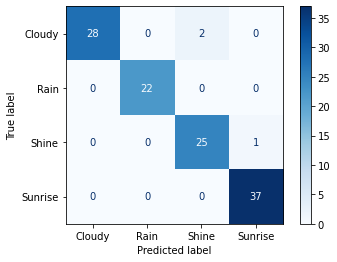

8.2



              precision    recall  f1-score   support

      Cloudy       1.00      0.93      0.97        30
        Rain       1.00      1.00      1.00        22
       Shine       0.93      0.96      0.94        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.97       115
   macro avg       0.97      0.97      0.97       115
weighted avg       0.97      0.97      0.97       115

15/15 [==============================] - 2s 119ms/step - loss: 0.0736 - accuracy: 0.9739

 Test accuracy: 97.39130139350891 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 235ms/step


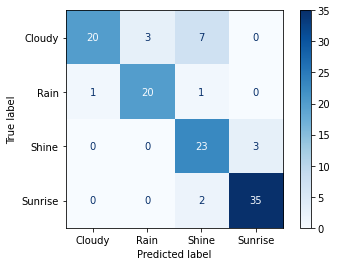

8.3



              precision    recall  f1-score   support

      Cloudy       0.95      0.67      0.78        30
        Rain       0.87      0.91      0.89        22
       Shine       0.70      0.88      0.78        26
     Sunrise       0.92      0.95      0.93        37

    accuracy                           0.85       115
   macro avg       0.86      0.85      0.85       115
weighted avg       0.87      0.85      0.85       115

15/15 [==============================] - 2s 118ms/step - loss: 0.4120 - accuracy: 0.8522

 Test accuracy: 85.2173924446106 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 235ms/step


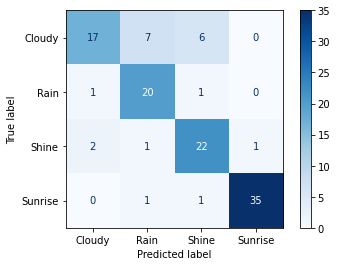

100



              precision    recall  f1-score   support

      Cloudy       0.85      0.57      0.68        30
        Rain       0.69      0.91      0.78        22
       Shine       0.73      0.85      0.79        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.82       115
   macro avg       0.81      0.82      0.80       115
weighted avg       0.83      0.82      0.81       115

15/15 [==============================] - 2s 119ms/step - loss: 0.5202 - accuracy: 0.8174

 Test accuracy: 81.73912763595581 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 215ms/step


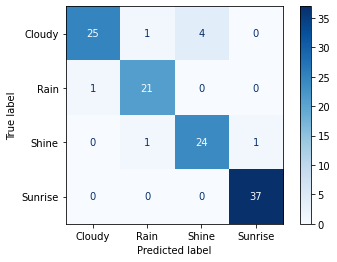

12



              precision    recall  f1-score   support

      Cloudy       0.96      0.83      0.89        30
        Rain       0.91      0.95      0.93        22
       Shine       0.86      0.92      0.89        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115

15/15 [==============================] - 2s 112ms/step - loss: 0.4033 - accuracy: 0.9304

 Test accuracy: 93.04347634315491 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 215ms/step


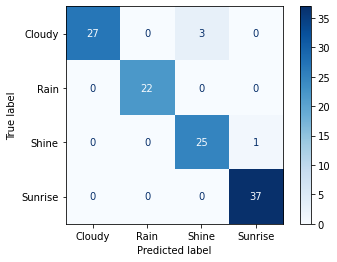

13



              precision    recall  f1-score   support

      Cloudy       1.00      0.90      0.95        30
        Rain       1.00      1.00      1.00        22
       Shine       0.89      0.96      0.93        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.97       115
   macro avg       0.97      0.97      0.96       115
weighted avg       0.97      0.97      0.97       115

15/15 [==============================] - 2s 111ms/step - loss: 0.0795 - accuracy: 0.9652

 Test accuracy: 96.52174115180969 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 205ms/step


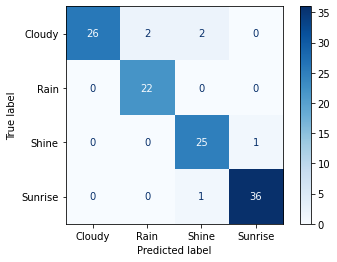

121



              precision    recall  f1-score   support

      Cloudy       1.00      0.87      0.93        30
        Rain       0.92      1.00      0.96        22
       Shine       0.89      0.96      0.93        26
     Sunrise       0.97      0.97      0.97        37

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115

15/15 [==============================] - 2s 111ms/step - loss: 0.2895 - accuracy: 0.9478

 Test accuracy: 94.7826087474823 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 149ms/step


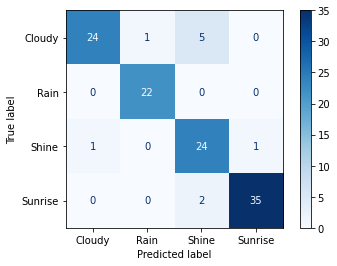

5



              precision    recall  f1-score   support

      Cloudy       0.96      0.80      0.87        30
        Rain       0.96      1.00      0.98        22
       Shine       0.77      0.92      0.84        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.91       115
   macro avg       0.92      0.92      0.91       115
weighted avg       0.92      0.91      0.91       115

15/15 [==============================] - 2s 98ms/step - loss: 0.4061 - accuracy: 0.9130

 Test accuracy: 91.30434989929199 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 251ms/step


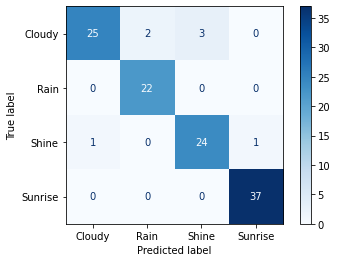

15



              precision    recall  f1-score   support

      Cloudy       0.96      0.83      0.89        30
        Rain       0.92      1.00      0.96        22
       Shine       0.89      0.92      0.91        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.94       115
   macro avg       0.94      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115

15/15 [==============================] - 2s 125ms/step - loss: 0.2179 - accuracy: 0.9391

 Test accuracy: 93.9130425453186 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 216ms/step


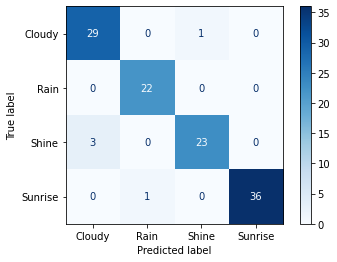

8



              precision    recall  f1-score   support

      Cloudy       0.91      0.97      0.94        30
        Rain       0.96      1.00      0.98        22
       Shine       0.96      0.88      0.92        26
     Sunrise       1.00      0.97      0.99        37

    accuracy                           0.96       115
   macro avg       0.96      0.96      0.95       115
weighted avg       0.96      0.96      0.96       115

15/15 [==============================] - 2s 112ms/step - loss: 0.0948 - accuracy: 0.9565

 Test accuracy: 95.652174949646 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 219ms/step


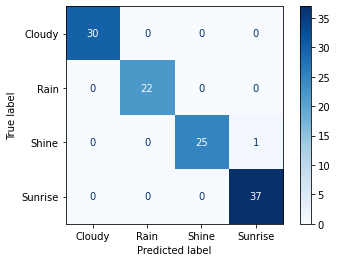

9



              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00        30
        Rain       1.00      1.00      1.00        22
       Shine       1.00      0.96      0.98        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.99       115
   macro avg       0.99      0.99      0.99       115
weighted avg       0.99      0.99      0.99       115

15/15 [==============================] - 2s 116ms/step - loss: 0.0865 - accuracy: 0.9913

 Test accuracy: 99.1304337978363 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 217ms/step


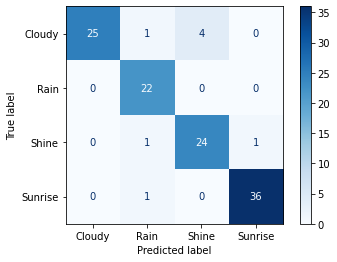

11



              precision    recall  f1-score   support

      Cloudy       1.00      0.83      0.91        30
        Rain       0.88      1.00      0.94        22
       Shine       0.86      0.92      0.89        26
     Sunrise       0.97      0.97      0.97        37

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.94      0.93      0.93       115

15/15 [==============================] - 2s 116ms/step - loss: 0.2873 - accuracy: 0.9304

 Test accuracy: 93.04347634315491 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 2s 398ms/step


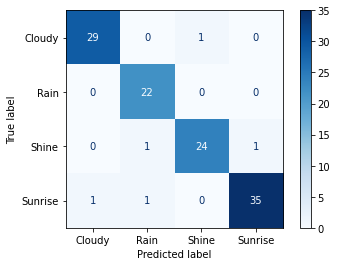

19



              precision    recall  f1-score   support

      Cloudy       0.97      0.97      0.97        30
        Rain       0.92      1.00      0.96        22
       Shine       0.96      0.92      0.94        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.96       115
   macro avg       0.95      0.96      0.96       115
weighted avg       0.96      0.96      0.96       115

15/15 [==============================] - 3s 156ms/step - loss: 0.1775 - accuracy: 0.9565

 Test accuracy: 95.652174949646 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 220ms/step


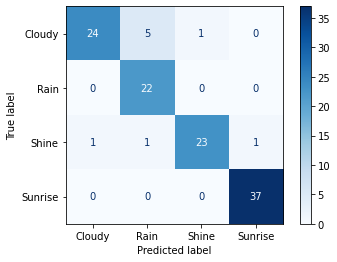

18



              precision    recall  f1-score   support

      Cloudy       0.96      0.80      0.87        30
        Rain       0.79      1.00      0.88        22
       Shine       0.96      0.88      0.92        26
     Sunrise       0.97      1.00      0.99        37

    accuracy                           0.92       115
   macro avg       0.92      0.92      0.91       115
weighted avg       0.93      0.92      0.92       115

15/15 [==============================] - 2s 115ms/step - loss: 0.3416 - accuracy: 0.9217

 Test accuracy: 92.17391014099121 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 270ms/step


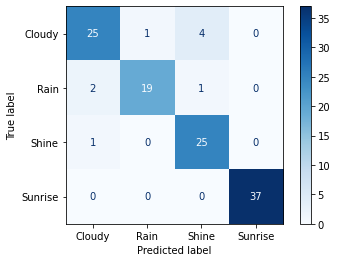

14



              precision    recall  f1-score   support

      Cloudy       0.89      0.83      0.86        30
        Rain       0.95      0.86      0.90        22
       Shine       0.83      0.96      0.89        26
     Sunrise       1.00      1.00      1.00        37

    accuracy                           0.92       115
   macro avg       0.92      0.91      0.91       115
weighted avg       0.92      0.92      0.92       115

15/15 [==============================] - 3s 191ms/step - loss: 1.7423 - accuracy: 0.9217

 Test accuracy: 92.17391014099121 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 220ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


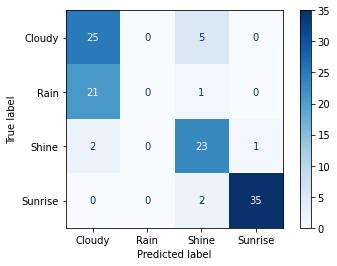

1666



              precision    recall  f1-score   support

      Cloudy       0.52      0.83      0.64        30
        Rain       0.00      0.00      0.00        22
       Shine       0.74      0.88      0.81        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.72       115
   macro avg       0.56      0.67      0.60       115
weighted avg       0.62      0.72      0.66       115

15/15 [==============================] - 2s 119ms/step - loss: 0.6284 - categorical_accuracy: 0.7217

 Test accuracy: 72.1739113330841 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 221ms/step


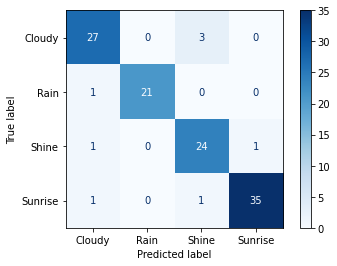

16



              precision    recall  f1-score   support

      Cloudy       0.90      0.90      0.90        30
        Rain       1.00      0.95      0.98        22
       Shine       0.86      0.92      0.89        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115

15/15 [==============================] - 2s 105ms/step - loss: 0.1768 - categorical_accuracy: 0.9304

 Test accuracy: 93.04347634315491 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


4/4 [==============================] - 1s 222ms/step


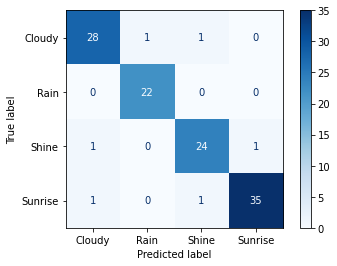

17



              precision    recall  f1-score   support

      Cloudy       0.93      0.93      0.93        30
        Rain       0.96      1.00      0.98        22
       Shine       0.92      0.92      0.92        26
     Sunrise       0.97      0.95      0.96        37

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115

15/15 [==============================] - 2s 120ms/step - loss: 0.1426 - categorical_accuracy: 0.9478

 Test accuracy: 94.7826087474823 %


 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************

 **************


OSError: ignored

In [ ]:
batch_size=64
from keras.models import load_model
import os 
x='/content/drive/MyDrive/ML Project 1/'
d={}
for val in os.listdir(x):
    path_to_model = "{}/model{}.h5".format((x+val),val)
    model = load_model(path_to_model)
    Y_pred_res = model.predict_generator(test_generator, test_generator.n // (batch_size+1),)
    y_pred_res = np.argmax(Y_pred_res, axis=1)
    # y_pred_res
    from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,classification_report
    class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
    n = 14

    image_batch, classes_batch = next(test_generator)

    for batch in range(n):
        temp = next(test_generator)
        image_batch = np.concatenate((image_batch, temp[0]))
        classes_batch = np.concatenate((classes_batch, temp[1]))

    classes_batch = classes_batch
    y_predict = model.predict(image_batch)

    ConfusionMatrixDisplay.from_predictions(
        y_true = [np.argmax(x) for x in classes_batch],
        #y_true = classes_batch.
        y_pred = [np.argmax(x) for x in y_predict],
        #y_pred = y_predict,
        display_labels=class_names,
        cmap='Blues'
    )
    y_true = [np.argmax(x) for x in classes_batch]
        #y_true = classes_batch.
    y_pred = [np.argmax(x) for x in y_predict]
    clf=classification_report( y_true,y_pred,target_names=class_names)
    # plt.savefig('./confusion_matrix.png')                                       
    plt.show()
    print(val)
    print("\n\n")
    print(clf)
    score = model.evaluate(test_generator,verbose=1,)
    print('\n', 'Test accuracy:', score[1]*100,"%")
    d[val]=score[1]*100
    print("\n\n **************"*10)


# All plots

****************************************** 4 




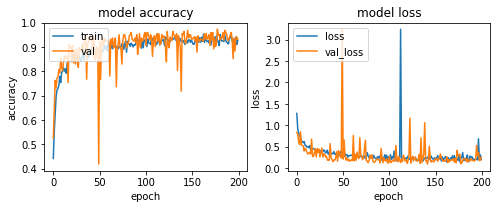

****************************************** 3 




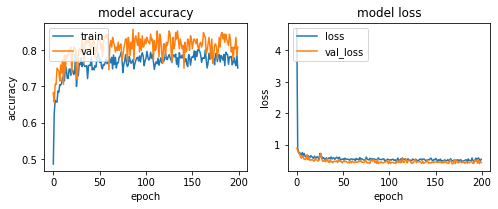

****************************************** 2 




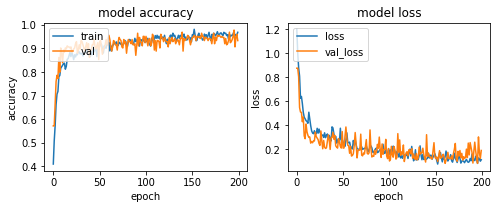

****************************************** 1 




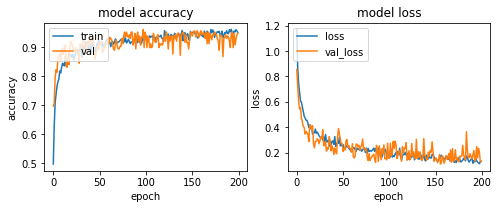

****************************************** 8.1 




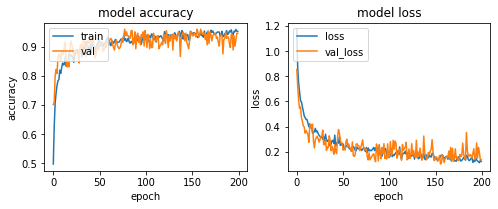

****************************************** 8.2 




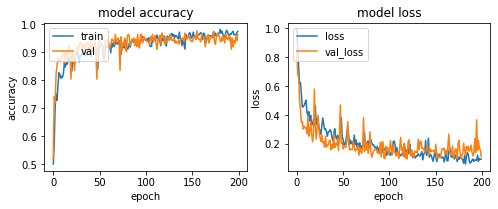

****************************************** 8.3 




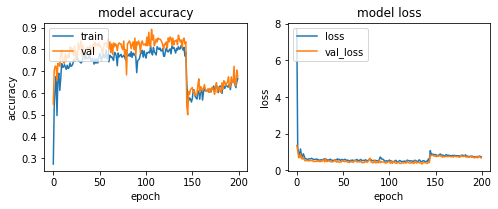

****************************************** 100 




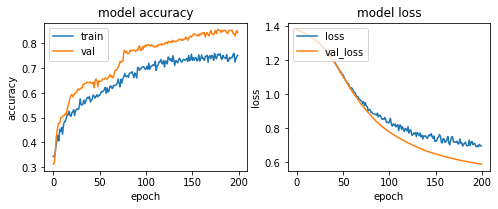

****************************************** 12 




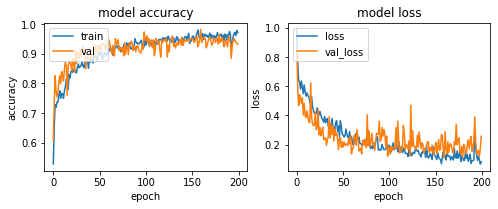

****************************************** 13 




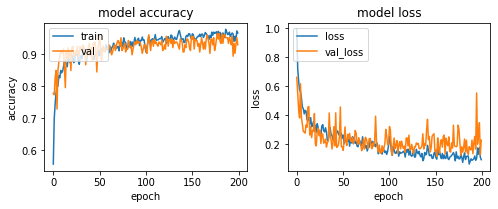

****************************************** 121 




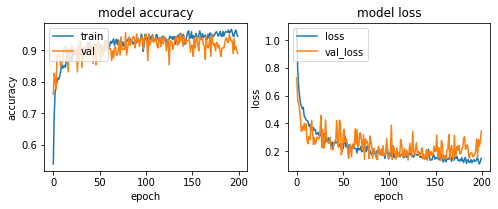

****************************************** 5 




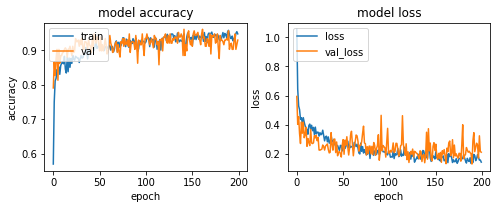

****************************************** 15 




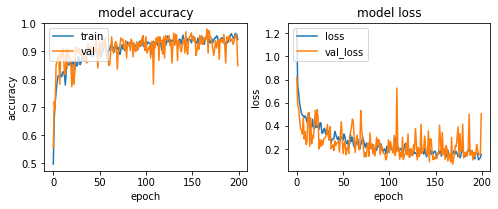

****************************************** 8 




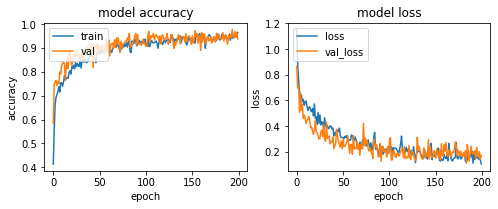

****************************************** 9 




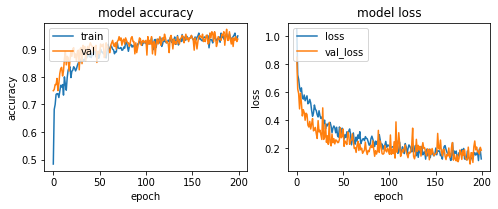

****************************************** 11 




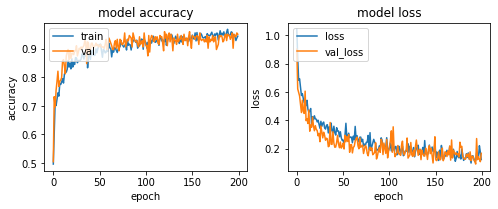

****************************************** 19 




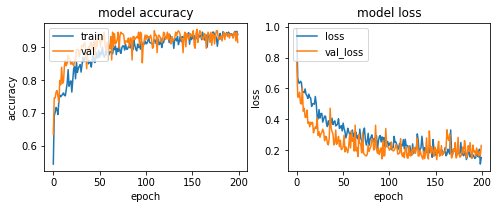

****************************************** 18 




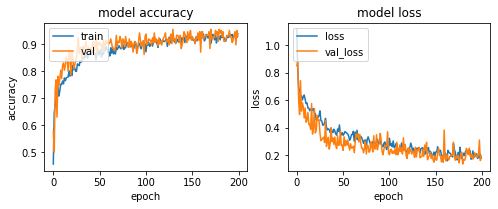

****************************************** 14 




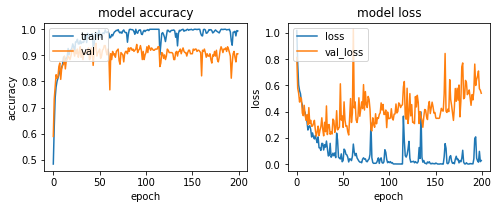

****************************************** 1666 


NOT Parsed XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 1666
****************************************** 16 


NOT Parsed XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 16
****************************************** 17 


NOT Parsed XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 17
****************************************** 34 




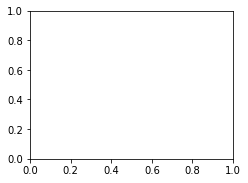

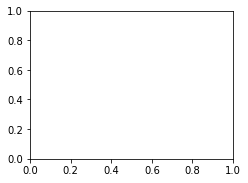

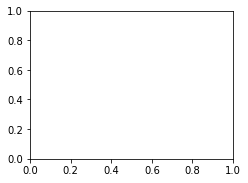

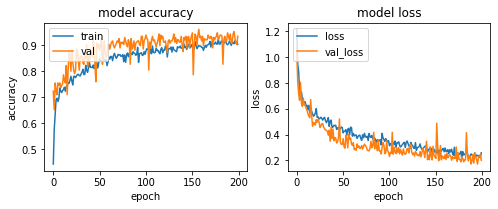

****************************************** 35 


NOT Parsed XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 35
****************************************** .ipynb_checkpoints 


NOT Parsed XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX .ipynb_checkpoints


In [ ]:
import os 
x='/content/drive/MyDrive/ML Project 1/'
import json
import pandas as pd
# f=pd.read_json('/content/drive/MyDrive/ML Project 1/1/history1.json',).reset_index(drop=True)
for val in os.listdir(x):
    # path_to_model = "{}/model{}.h5".format((x+val),val)
    try:
        print("***"*14,val,"\n\n")
            
        f=pd.read_json(x+val+"/history{}.json".format(val))
        history=f.iloc[:200,:]
        ##SAVE PLOTS OF ACCURACY AND LOSS
        fig =plt.figure(figsize=(8, 6))
        plt.subplot(2, 2, 1)
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']

        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')


        plt.subplot(2, 2, 2)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.show()
        
    except:
        print("NOT Parsed","XXX"*27, val)    
        

## Confidence interval


                            Classifier2 Correct,	Classifier2 Incorrect

---


    Classifier1 Correct 	Yes/Yes					Yes/No 
    Classifier1 Incorrect 	No/Yes 					No/No

In [ ]:
25+21+23+37

106

In [ ]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[106, 5],
		 [3, 1]]
# calculate mcnemar test
result = mcnemar(table, correction=True,)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=3.000, p-value=0.727
Same proportions of errors (fail to reject H0)


In [ ]:
train_model('adam','val_accuracy','max',500,32,124,15,'relu','categorical_accuracy')

In [ ]:
!git clone "https://github.com/GiovanniCiampi/confidence_interval_estimator_ML.git"

Cloning into 'confidence_interval_estimator_ML'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 116 (delta 62), reused 27 (delta 10), pack-reused 0
Receiving objects: 100% (116/116), 147.63 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (62/62), done.


Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.58929, saving model to model_weight14.hdf5
99/99 - 7s - loss: 1.0178 - accuracy: 0.4835 - val_loss: 0.8123 - val_accuracy: 0.5893 - 7s/epoch - 69ms/step
Epoch 2/500

Epoch 2: val_accuracy improved from 0.58929 to 0.73214, saving model to model_weight14.hdf5
99/99 - 6s - loss: 0.7605 - accuracy: 0.6234 - val_loss: 0.5777 - val_accuracy: 0.7321 - 6s/epoch - 60ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.73214 to 0.78125, saving model to model_weight14.hdf5
99/99 - 6s - loss: 0.6029 - accuracy: 0.7366 - val_loss: 0.5401 - val_accuracy: 0.7812 - 6s/epoch - 61ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.78125 to 0.82589, saving model to model_weight14.hdf5
99/99 - 6s - loss: 0.5598 - accuracy: 0.7786 - val_loss: 0.4725 - val_accuracy: 0.8259 - 6s/epoch - 64ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.82589
99/99 - 6s - loss: 0.5354 - accuracy: 0.8003 - val_loss: 0.5075 - val_accuracy:

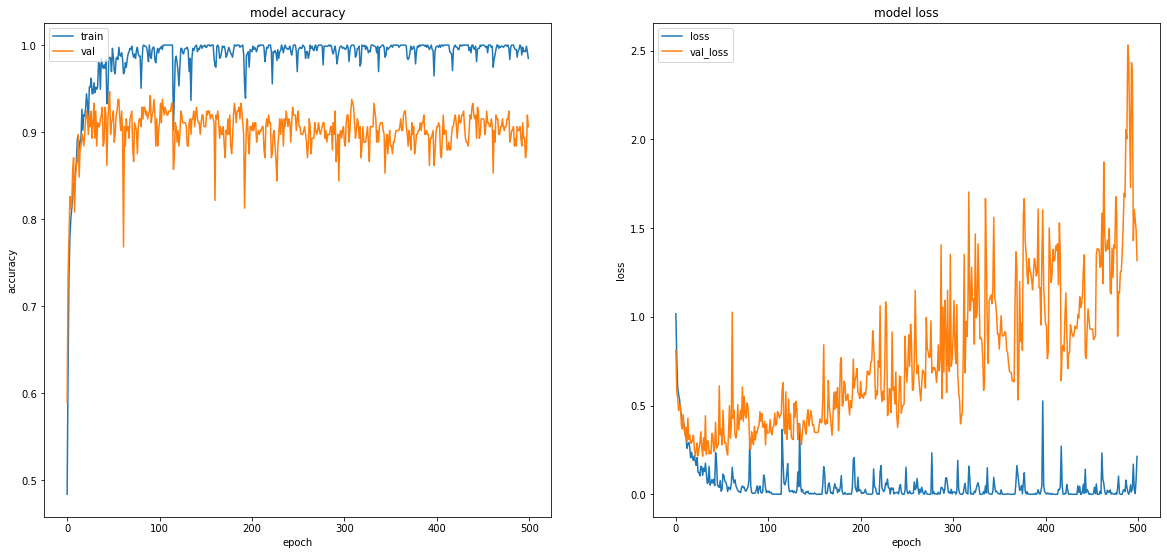

15/15 [==============================] - 1s 57ms/step - loss: 1.7423 - accuracy: 0.9217

 Test accuracy: 92.17391014099121 %


[1.7422720193862915, 0.9217391014099121]

In [ ]:
train_model('adam','val_accuracy','max',500,32,14,15)

Epoch 1/3

Epoch 1: val_categorical_accuracy improved from -inf to 0.76339, saving model to model_weight1666.hdf5
99/99 - 45s - loss: 0.9185 - categorical_accuracy: 0.5560 - val_loss: 0.6340 - val_categorical_accuracy: 0.7634 - 45s/epoch - 450ms/step
Epoch 2/3

Epoch 2: val_categorical_accuracy did not improve from 0.76339
99/99 - 35s - loss: 0.7169 - categorical_accuracy: 0.6921 - val_loss: 0.7005 - val_categorical_accuracy: 0.7098 - 35s/epoch - 355ms/step
Epoch 3/3

Epoch 3: val_categorical_accuracy did not improve from 0.76339
99/99 - 35s - loss: 0.6512 - categorical_accuracy: 0.6972 - val_loss: 0.7031 - val_categorical_accuracy: 0.6696 - 35s/epoch - 354ms/step
Model Trained and Saved


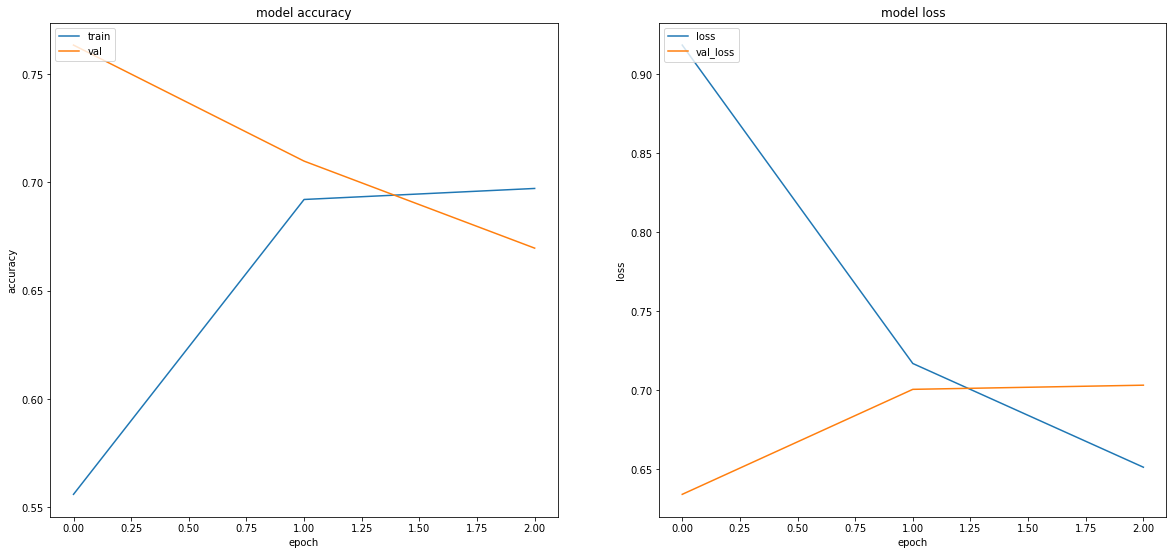

15/15 [==============================] - 2s 112ms/step - loss: 0.7162 - categorical_accuracy: 0.6783

 Test accuracy: 67.8260862827301 %


[0.7162163853645325, 0.678260862827301]

In [ ]:
train_model('adam','val_categorical_accuracy','max',3,32,1666,15,'relu','categorical_accuracy')

# train_model('adam','val_categorical_accuracy','max',500,32,16,15,'relu','categorical_accuracy')
# train_model('adam','val_categorical_accuracy','max',500,8,17,15,'relu','categorical_accuracy')

Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.63393, saving model to model_weight19.hdf5
99/99 - 21s - loss: 0.9837 - accuracy: 0.5433 - val_loss: 0.7808 - val_accuracy: 0.6339 - 21s/epoch - 209ms/step
Epoch 2/500

Epoch 2: val_accuracy improved from 0.63393 to 0.74554, saving model to model_weight19.hdf5
99/99 - 9s - loss: 0.6697 - accuracy: 0.6908 - val_loss: 0.5458 - val_accuracy: 0.7455 - 9s/epoch - 86ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.74554
99/99 - 8s - loss: 0.6365 - accuracy: 0.7010 - val_loss: 0.5434 - val_accuracy: 0.7455 - 8s/epoch - 85ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.74554 to 0.76339, saving model to model_weight19.hdf5
99/99 - 8s - loss: 0.6343 - accuracy: 0.7163 - val_loss: 0.5754 - val_accuracy: 0.7634 - 8s/epoch - 85ms/step
Epoch 5/500

Epoch 5: val_accuracy improved from 0.76339 to 0.76786, saving model to model_weight19.hdf5
99/99 - 8s - loss: 0.6470 - accuracy: 0.7099 - val_loss: 0.5028 - val_accura

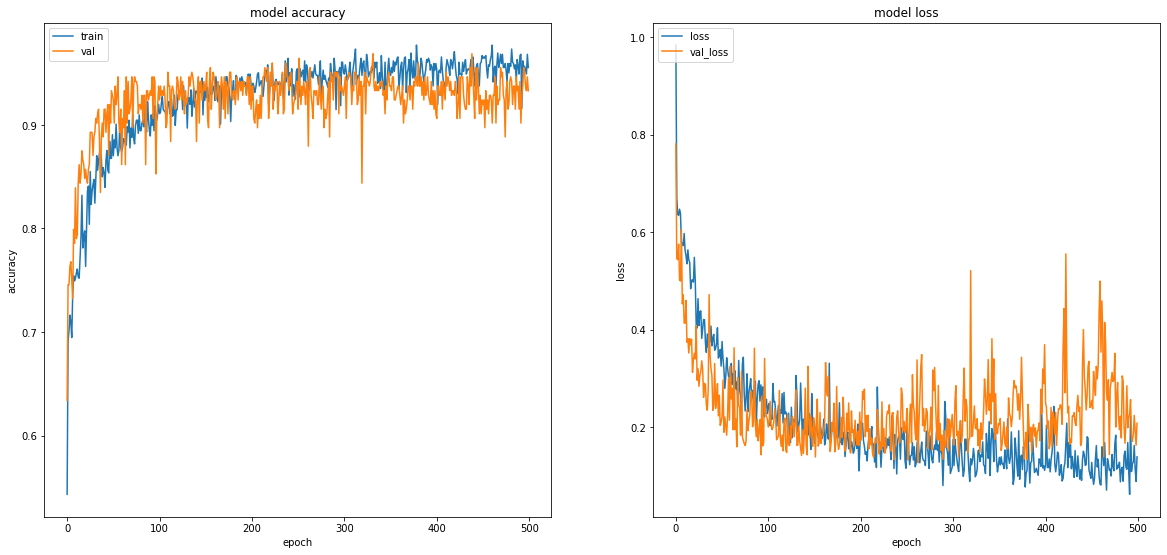

15/15 [==============================] - 1s 58ms/step - loss: 0.1775 - accuracy: 0.9565

 Test accuracy: 95.652174949646 %
Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.57589, saving model to model_weight18.hdf5
99/99 - 9s - loss: 1.1156 - accuracy: 0.4555 - val_loss: 0.8509 - val_accuracy: 0.5759 - 9s/epoch - 94ms/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.57589
99/99 - 9s - loss: 0.8284 - accuracy: 0.6450 - val_loss: 0.8764 - val_accuracy: 0.5000 - 9s/epoch - 86ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.57589 to 0.72768, saving model to model_weight18.hdf5
99/99 - 9s - loss: 0.6926 - accuracy: 0.6743 - val_loss: 0.5968 - val_accuracy: 0.7277 - 9s/epoch - 87ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.72768 to 0.76786, saving model to model_weight18.hdf5
99/99 - 9s - loss: 0.6708 - accuracy: 0.7074 - val_loss: 0.4962 - val_accuracy: 0.7679 - 9s/epoch - 87ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.767

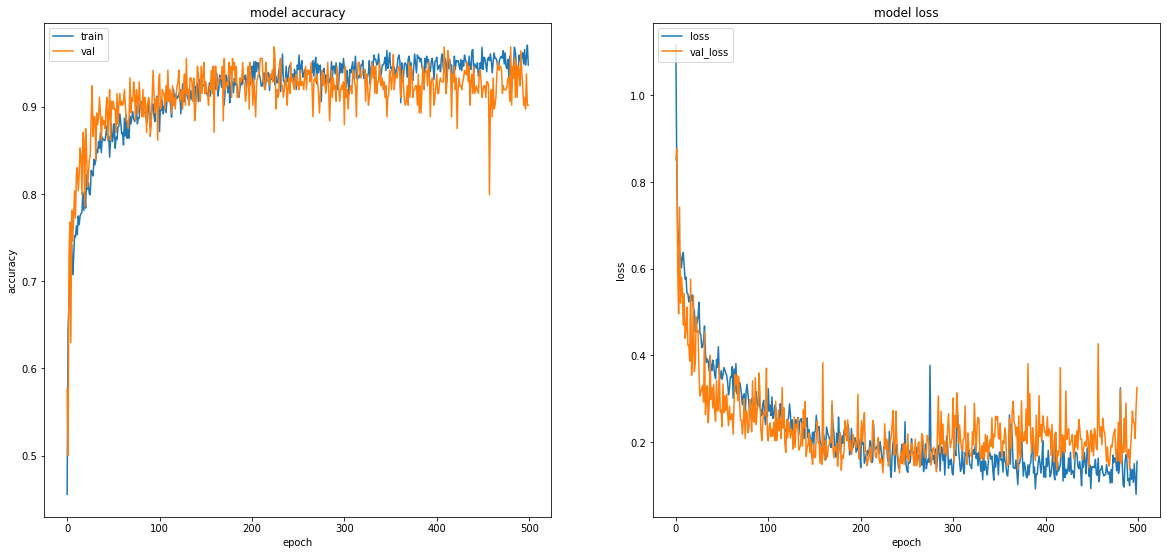

15/15 [==============================] - 1s 53ms/step - loss: 0.3416 - accuracy: 0.9217

 Test accuracy: 92.17391014099121 %


[0.3416065275669098, 0.9217391014099121]

In [ ]:
train_model('adam','val_accuracy','max',500,8,19,15)
train_model('adam','val_accuracy','max',500,32,18,15)

In [ ]:
## Categorical accuracy
train_model('adam','val_accuracy','max',500,8,29,15,'relu',"categorical_accuracy")
train_model('adam','val_accuracy','max',500,32,28,15,'relu',"categorical_accuracy")

Epoch 1/500


99/99 - 9s - loss: 1.1474 - categorical_accuracy: 0.4466 - val_loss: 0.8479 - val_categorical_accuracy: 0.6875 - 9s/epoch - 92ms/step
Epoch 2/500


99/99 - 10s - loss: 0.7969 - categorical_accuracy: 0.6565 - val_loss: 0.5890 - val_categorical_accuracy: 0.6875 - 10s/epoch - 98ms/step
Epoch 3/500


KeyboardInterrupt: ignored

In [ ]:
leaky_relu=tf.keras.layers.LeakyReLU(alpha=0.3)
leaky_relu2=tf.keras.layers.LeakyReLU(alpha=0.9)
leaky_relu3=tf.keras.layers.LeakyReLU(alpha=0.1)

In [ ]:
# def lr_schd(optimizer):
#     def lr(y_true, y_pred):
#         return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
#     return lr

# optimizer = keras.optimizers.Adam()
# lr_schd = lr_schd(optimizer)

# model.compile(
#     optimizer=optimizer,
#     metrics=['accuracy', lr_schd],
#     loss='mean_absolute_error', 
    

In [ ]:
train_model('adam','loss','min',500,32,15,15)

In [ ]:
tf.keras.backend.clear_session()
train_model('adam','val_accuracy','max',500,32,15,15,leaky_relu)

In [ ]:
tf.keras.backend.clear_session()
train_model('adam','val_accuracy','max',500,32,16,15,leaky_relu2)

In [ ]:
tf.keras.backend.clear_session()
train_model('adam','val_accuracy','max',500,32,17,15,leaky_relu3)

In [ ]:
# clip_by_value,
adam=tf.keras.optimizers.Adam(learning_rate=0.0001)
# adam2=tf.keras.optimizers.Adam(learning_rate=0.001,clip_by_value=)
adam3=tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
from scipy.linalg.decomp_svd import clip
from tensorflow.python.ops.math_ops import ClipByValue
adam22=tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=0.5)

In [ ]:

train_model('adam','val_accuracy','max',500,32,8,15)


In [ ]:
train_model('adam','val_accuracy','max',500,32,9,15)

In [ ]:
train_model('adam','val_accuracy','max',500,8,9,15)

In [ ]:
train_model('adam','val_accuracy','max',500,64,11,15)

In [ ]:
def train_model2(optimizer,monitor,mode,epochs,batch_size,c,wait=20,activation='relu',metrics = ['accuracy']):
    ## Defining model architecture

    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation=activation, input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        # tf.keras.layers.Dropout(0.4,seed=1),
        
        tf.keras.layers.Conv2D(128, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        # tf.keras.layers.Dropout(0.5,seed=1),
        
        tf.keras.layers.Conv2D(128, (3,3), activation=activation),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation=activation),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                optimizer =optimizer ,
                metrics = metrics,)
    filepath="model_weight{}.hdf5".format(c)
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2,
                              patience=5, min_lr=0.00001,)
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, mode=mode)
    es = EarlyStopping(monitor=monitor,mode=mode,patience=wait)
    callbacks_list = [checkpoint]
    history = model.fit(
        train_generator,
        batch_size=batch_size,  
        epochs = epochs,
        callbacks=[callbacks_list],
        verbose = 2,
        validation_data=validation_generator)
    
    ##SAVE MODEL ARCHITECTURE AND WEIGHT
    
    with open('history{}.json'.format(c), 'w') as f:
        json.dump(history.history, f)
    model.save("model{}.h5".format(c))  
    print("Model Trained and Saved")  
    os.makedirs('/content/drive/MyDrive/ML Project 1/{}'.format(c),exist_ok=True) 
    shutil.copy("model{}.h5".format(c) ,"/content/drive/MyDrive/ML Project 1/{}".format(c))
    shutil.copy("model_weight{}.hdf5".format(c), '/content/drive/MyDrive/ML Project 1/{}'.format(c))
    shutil.copy('history{}.json'.format(c), '/content/drive/MyDrive/ML Project 1/{}'.format(c))
    

    ##SAVE PLOTS OF ACCURACY AND LOSS
    fig =plt.figure(figsize=(8, 6))
    plt.subplot(2, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')


    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()
    fig.savefig('/content/drive/MyDrive/ML Project 1/{}/plot.jpg'.format(c))

    score = model.evaluate(test_generator,verbose=1,)

    print('\n', 'Test accuracy:', score[1]*100,"%")

    return score

In [ ]:
train_model('adam','val_accuracy','max',500,32,10,15)

In [ ]:
tf.keras.backend.clear_session()
train_model2('adam','loss','min',500,32,12,15)
# tf.keras.backend.clear_session()

In [ ]:
# tf.keras.backend.clear_session()
# train_model(adam2,'loss','min',500,32,12,15)
# tf.keras.backend.clear_session()
# train_model(adam2,'loss','min',500,32,13,15)
# tf.keras.backend.clear_session()
# train_model(adam3,'loss','min',500,32,14,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam2,'loss','min',500,8,5900,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam2,'loss','min',500,8,50,15)
tf.keras.backend.clear_session()
train_model(adam2,'val_loss','min',500,16,51,15)
tf.keras.backend.clear_session()
train_model(adam2,'val_loss','min',500,64,52,15)

In [ ]:
# !rm -r "/content/drive/MyDrive/ML Project 1/8.3"

In [ ]:
## (optimizer,monitor,mode,epochs,batch_size,c,wait=20):
# tf.keras.backend.clear_session()
# train_model(adam,'loss','min',500,32,1,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam2,'loss','min',500,32,2,15)

In [ ]:
# tf.keras.backend.clear_session()
train_model(adam3,'loss','min',200,32,333,15)

Epoch 1/200

Epoch 1: loss improved from inf to 1.48230, saving model to model_weight333.hdf5
99/99 - 38s - loss: 1.4823 - accuracy: 0.2990 - val_loss: 1.3690 - val_accuracy: 0.3170 - lr: 0.0100 - 38s/epoch - 380ms/step
Epoch 2/200

Epoch 2: loss improved from 1.48230 to 1.37445, saving model to model_weight333.hdf5
99/99 - 39s - loss: 1.3745 - accuracy: 0.3168 - val_loss: 1.3695 - val_accuracy: 0.3170 - lr: 0.0100 - 39s/epoch - 389ms/step
Epoch 3/200

Epoch 3: loss improved from 1.37445 to 1.37218, saving model to model_weight333.hdf5
99/99 - 36s - loss: 1.3722 - accuracy: 0.3168 - val_loss: 1.3692 - val_accuracy: 0.3170 - lr: 0.0100 - 36s/epoch - 368ms/step
Epoch 4/200

Epoch 4: loss did not improve from 1.37218
99/99 - 36s - loss: 1.3725 - accuracy: 0.3168 - val_loss: 1.3692 - val_accuracy: 0.3170 - lr: 0.0100 - 36s/epoch - 365ms/step
Epoch 5/200

Epoch 5: loss did not improve from 1.37218
99/99 - 36s - loss: 1.3724 - accuracy: 0.3168 - val_loss: 1.3700 - val_accuracy: 0.3170 - lr: 

KeyboardInterrupt: ignored

In [ ]:
# tf.keras.backend.clear_session()
train_model('rmsprop','loss','min',500,32,4,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam,'val_accuracy','max',500,32,8.1,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam2,'val_accuracy','max',500,32,8.2,15)

In [ ]:
tf.keras.backend.clear_session()
train_model(adam3,'val_accuracy','max',500,32,8.3,15)

In [ ]:
adam_low=tf.keras.optimizers.Adam(learning_rate=0.000001)
tf.keras.backend.clear_session()
train_model(adam_low,'loss','min',500,32,100,15)

## Test Images

In [ ]:
model2 = keras.models.load_model('/content/drive/MyDrive/ML Project 1/good.h5')

In [ ]:
def test_images(model, num_images = None):  
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0] if num_images is None else num_images):
        image = image_batch[k]
        real_class = class_names[np.argmax(classes_batch[k],axis=-1)]
        predicted_class = class_names[np.argmax(predicted_batch[k],axis=-1)]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)
        plt.figure(k,figsize=(6,4),)
        plt.title("Prediction - " + str("Correct\n" if isTrue else "Wrong")
         +'\nActual_Class: ' + real_class + '\nPredicted_class: ' +
          predicted_class +"\nScore: "+ str(np.max(value_predicted)*100)+"%\n")
        plt.axis('off')
        # plt.savefig('./' + real_class + '_' + predicted_class + '_' + str(value_predicted) + '.png')
        plt.imshow(image)



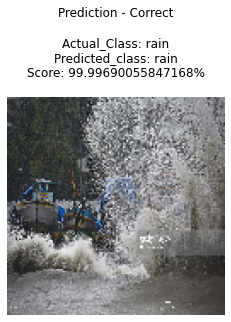

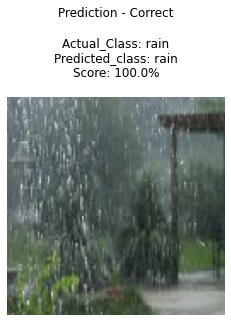

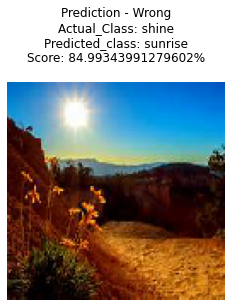

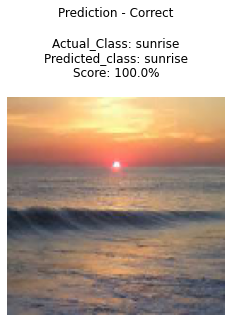

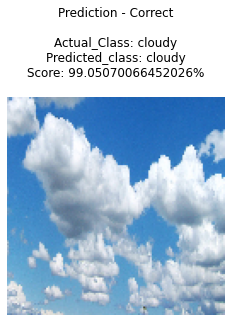

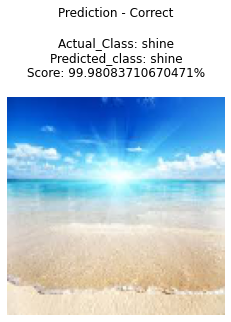

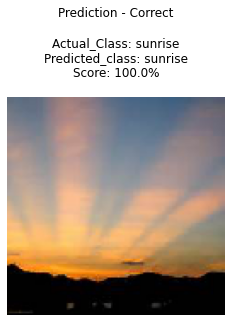

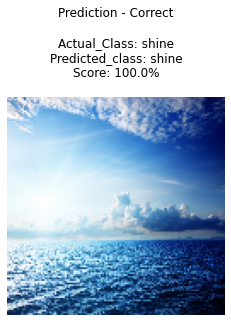

In [ ]:
test_images(model2,8)

In [ ]:
test_generator.n

115

In [ ]:
image_batch.shape

(32, 128, 128, 3)

In [ ]:
model2=model
batch_size=64
Y_pred_res = model2.predict_generator(test_generator, test_generator.n // (batch_size+1),)
y_pred_res = np.argmax(Y_pred_res, axis=1)
y_pred_res

NameError: ignored

In [ ]:
test_generator.class_indices

In [ ]:
##https://www.kaggle.com/code/lomitofrito/punto4-parcial-emergentes/notebook

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,classification_report
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
n = 14

image_batch, classes_batch = next(test_generator)

for batch in range(n):
    temp = next(test_generator)
    image_batch = np.concatenate((image_batch, temp[0]))
    classes_batch = np.concatenate((classes_batch, temp[1]))

classes_batch = classes_batch
y_predict = model2.predict(image_batch)

ConfusionMatrixDisplay.from_predictions(
    y_true = [np.argmax(x) for x in classes_batch],
    #y_true = classes_batch.
    y_pred = [np.argmax(x) for x in y_predict],
    #y_pred = y_predict,
    display_labels=class_names,
    cmap='Blues'
)
y_true = [np.argmax(x) for x in classes_batch]
    #y_true = classes_batch.
y_pred = [np.argmax(x) for x in y_predict]
clf=classification_report( y_true,y_pred,target_names=class_names)
# plt.savefig('./confusion_matrix.png')                                       
plt.show()
print("\n\n")
print(clf)


In [ ]:

print('\n', 'Test accuracy:', score[1]*100,"%")


15/15 [==============================] - 2s 124ms/step - loss: 0.1834 - accuracy: 0.9565

 Test accuracy: 95.652174949646 %


In [ ]:
test_generator.samples

115

In [ ]:
len(y_pred)

24

In [ ]:
print(clf)

              precision    recall  f1-score   support

      Cloudy       1.00      0.86      0.93        29
        Rain       1.00      0.95      0.98        22
       Shine       0.84      0.93      0.89        29
     Sunrise       0.95      1.00      0.97        35

    accuracy                           0.94       115
   macro avg       0.95      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115



In [ ]:
print(clf)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        85
           1       1.00      0.95      0.97        60
           2       0.84      0.95      0.89        64
           3       0.97      1.00      0.99       104

    accuracy                           0.95       313
   macro avg       0.95      0.95      0.95       313
weighted avg       0.96      0.95      0.95       313

